In [6]:
%config InlineBackend.figure_format = 'svg' # change output plot display format to 'svg'

# import the required modules for this notebook
import numpy
import matplotlib.pyplot as plt
# import the helper functions from the parent directory,
# these help with things like graph plotting and notebook layout
import sys
sys.path.append('..')
from helper_functions import *

# set things like fonts etc - comes from helper_functions
set_notebook_preferences()

# add a show/hide code button - also from helper_functions
toggle_code(title = "setup code")

## The K-means algorithm

Suppose we are given the following dataset $\{\mathbf{x}_n\}_{n=1}^N$ comprising two-dimensional real valued data points $\mathbf{x}_n = [x_{1,n},x_{2,n}]^\top$. We are asked to automatically cluster the points into three clusters.

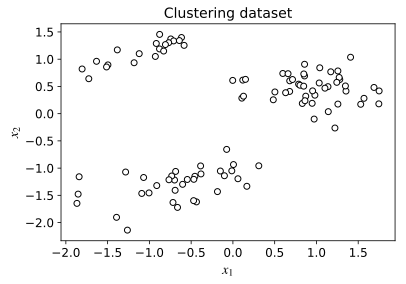

In [7]:
x = np.load('clustering_2d.npy')

plt.scatter(x[:, 0], x[:, 1], marker = 'o', color = 'white', edgecolor = 'black')
beautify_plot({"title":"Clustering dataset", "x":"$x_1$", "y":"$x_2$"})
plt.show()

toggle_code("loading the dataset")

One way to proceed is to use the K-means algorithm. We assume there are $K$ clusters with centres $\{ \mathbf{m}_k \}_{k=1}^K$. Each datapoint is will be assigned to one of these clusters. 

There are two ways of denoting this assignment. The simplest is to use $s_n=k$ to denote that the $n^{\text{th}}$ datapoint is assigned to the  $k^{\text{th}}$ cluster. An alternative, which will lead to more compact mathematical expressions, is to use the 1-of-K indicator $s_{n,k}$. Here $s_{n,k} = 1$ means the $n^{\text{th}}$ point belongs to the $k^{\text{th}}$ class and all other $s_{n,k'} = 0$ for $k' \ne k$. In this way the assignment for the entire dataset can be written in terms of an $N$ by $K$ matrix $S$ with elements $s_{n,k}$. For example, consider a dataset of four datapoints which are assigned to three clusters. The matrix

\begin{align}
S = 
\left [ \begin{array}{ccc}
0 & 0 & 1\\
1 & 0 & 0\\
0 & 1 & 0\\
0 & 1 & 0 
\end{array}
\right ] 
\end{align}

indicates that the first datapoint is assigned to cluster 3, the second to cluster 1, and the third and fourth to cluster 2. 

The K-means algorithm clusters the points by minimising the cost function

\begin{align}
\mathcal{C} = \sum_{n = 1}^N \sum_{k = 1}^K s_{n,k} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2
\end{align}

with respect to $s_{n,k}$ and $\mathbf{m}_k$. The cost function $\mathcal{C}$ is therefore the sum of squares of the distance of each datapoint from the cluster center to which it belongs: for given $n = n^\star$, the index $s_{n^\star k}$ contains a single $1$ at $k = k^\star$ and all other entries are $0$ for $k \neq k^\star$, the cost $\mathcal{C}$ gets a contribution $\lvert \lvert \mathbf{x}_{n^\star} - \mathbf{m}_{k^\star} \rvert \rvert^2$ from datapoint $n = n^\star$. By varying $s_{nk}$ and $\mathbf{m}_k$ to minimise $\mathcal{C}$, the algorithm effectively reallocates the points and shifts the cluster centers. This is achieved by repeating the two-step process:

1. Minimise $\mathcal{C}$ with respect to $\{s_{nk}\}$ keeping $\{\mathbf{m}_k\}$ fixed.


2. Minimise $\mathcal{C}$ with respect to $\{\mathbf{m}_k\}$ keeping $\{s_{nk}\}$ fixed.

This process is repeated until convergence, i.e. when the $\{s_{nk}\}$ no longer change. For each $n$, the $s_{nk}$ which minimises $\mathcal{C}$ for fixed $\{\mathbf{m}_k\}$ (remembering that $s_{nk}$ is a 1-of-K binary variable) is

\begin{align}
s_{nk} = 1 \text{ for } k = \text{arg } \min_{k} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2, \text{ and } s_{nk} = 0 \text{ for all other $k$}
\end{align}

The $\{\mathbf{m}_k\}$ which minimises $\mathcal{C}$ for fixed $s_{nk}$ can also be found easily by setting the derivative of $\mathcal{C}$ w.r.t. $\mathbf{m}_k$ equal to $0$:

\begin{align}
\frac{\partial \mathcal{C}}{\partial \mathbf{m}_k} &= \sum_{n = 1}^N s_{nk} (\mathbf{m}_k - \mathbf{x}_n)\\
~\\
&= \sum_{s_{nk} = 1}  (\mathbf{m}_k - \mathbf{x}_n) = 0\\
~\\
\implies \mathbf{m}_k &= \frac{1}{\sum_n s_{nk}}\sum_{s_{nk} = 1}\mathbf{x}_n = \frac{1}{N_k}\sum_{s_{nk} = 1}\mathbf{x}_n\\
\end{align}

where the sum $\sum_{s_{nk} = 1}$ denotes the sum over all datapoints for which $s_{nk} = 1$ for the given $k$, and $N_k = \sum_n s_{nk}$ is the number of datapoints in class $k$. Note also that this solution for $\mathbf{m}_k$ is simply the mean position of the datapoints belonging to that class.

Summarising the optimisation process:

1. Update $s_{nk} = 1 \text{ for } k = \text{arg } \min_{k} \lvert \lvert \mathbf{x}_n - \mathbf{m}_k \rvert \rvert^2, \text{ and } s_{nk} = 0 \text{ for all other $k$}$ keeping $\{\mathbf{m}_k\}$ fixed.

2. Update $\mathbf{m}_k = 1/N_k\sum_{s_{nk} = 1}\mathbf{x}_n$ keeping $\{s_{nk}\}$ fixed.

3. If the updated memberships $\{s_{nk}\}$ are the same as the previous ones, stop. If not repeat from 1.

Let's now apply k-means to the dataset. From a quick glance its clear that $K = 3$ clusters is appropriate. We use a completely random initialisation of class membership and cluster centers.

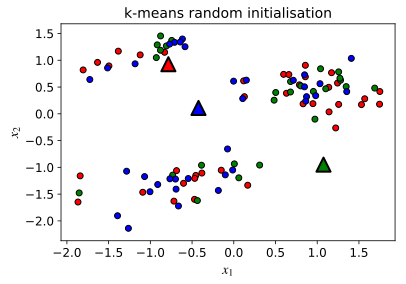

In [8]:
K, N = 3, x.shape[0]

mus = np.random.rand(K, 2)*4 - 2 # initialise cluster centers randomly in [-2, 2]
s = np.zeros(shape = (N, K)) # set all membership indices to 0
memberships = np.random.choice(np.arange(0, K), N) # randomly choose a cluster for each point
s[np.arange(s.shape[0]), memberships] = 1 # set the 1-entries according to the random sample
colors = ['r', 'g', 'b']

for idx, mu in enumerate(mus): # cycle over clusters
    plt.scatter(mu[0], mu[1], marker = '^', color = colors[idx], s = 200,
                edgecolor = 'black', zorder = 2, linewidth = '2') # plot cluster center
    
    points_in_class = x[np.where(s[:, idx] == 1)[0], :] # select points in current cluster ...
    
    plt.scatter(points_in_class[:, 0], points_in_class[:, 1], marker = 'o',
                color = colors[idx], edgecolor = 'black') # ... and plot
beautify_plot({"title":"k-means random initialisation", "x":"$x_1$", "y":"$x_2$"})
plt.show()

As you can see, the initial memberships and cluster centers are random and rerunning this cell will give a different initialisation. Now for the optimisation:

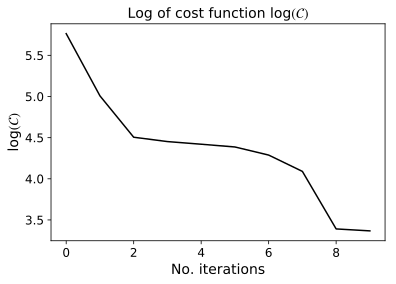

In [9]:
xs = np.stack([x]*K, axis = 1) # stack K copies of x to do calculation for each cluster
costs = [np.sum(s*np.sum((xs - mus)**2, axis = 2))] # array to store costs, containing 1st cost
converged = False

while not(converged):
    
    mus = (s.T).dot(x)/s.sum(axis = 0).reshape((-1, 1)) # compute 3 centers in one go
    
    distances = np.sum((xs - mus)**2, axis = 2) # distance of each point from each cluster mean
    min_idx = np.argmin(distances, axis = 1) # find which cluster mean is closest to each point
    s_prev = s.copy() # copy cluster memberships to compare with updated ones
    s = np.zeros_like(s) # reset class membership to all-0 array
    s[np.arange(s.shape[0]), min_idx] = 1 # assign each point to the closest cluster
    
    costs.append(np.sum(s*np.sum((xs - mus)**2, axis = 2))) # compute current cost and store
    s_same = np.argmax(s, axis = 1) == np.argmax(s_prev, axis = 1) # compare new/prev memberships
    converged = np.prod(s_same) # this will be 1 if new == prev and 0 otherwise

plt.plot(np.arange(len(costs)), np.log(costs), color = 'black')
beautify_plot({"title":"Log of cost function log$(\mathcal{C})$", "x":"No. iterations", "y":"log$(\mathcal{C})$"})
plt.show()

We first verify that the algorithm has carried out the desired optimisation by plotting the cost function as a function of the iteration number. As expected the cost steadily decreases as the optimisation progresses. We expected this since each step of the optimisation process is guaranteed to not increase the cost. At some point the cost function reaches a plateau and the optimisation algorithm stops as the class memberships no longer change. Let's visualise the algorithm's results:

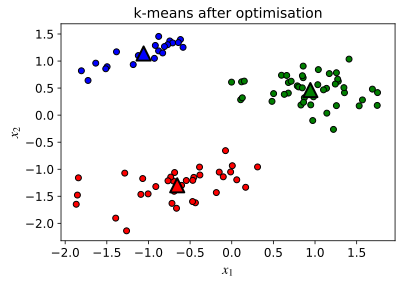

In [10]:
for idx, mu in enumerate(mus):
    plt.scatter(mu[0], mu[1], marker = '^', color = colors[idx], s = 200,
                edgecolor = 'black', zorder = 2, linewidth = '2')
    
    points_in_class = x[np.where(s[:, idx] == 1)[0], :]
    
    plt.scatter(points_in_class[:, 0], points_in_class[:, 1], marker = 'o',
                color = colors[idx], edgecolor = 'black', zorder = 1)
    
beautify_plot({"title":"k-means after optimisation", "x":"$x_1$", "y":"$x_2$"})
plt.show()

K-means returned sensible cluster assignments and the cluster centres look reasonable too. 

### Hang on, I have several questions about what we just did...

At this point you several important questions about the k-means algorithm arise:

- How do we choose the number of clusters $K$?

There are algorithms that learn $K$ from data. Some of these algorithms, like the Dirichlet Process Mixture Model, are based on the probabilistic view of clustering that we will consider next. However, these methods typically take a long time to train. In practice, practioners often run the k-means algorithm with different numbers of clusters and inspect the results to determine a suitable setting.

- Does the k-means algorithm converge or is there a chance it might not for certain datasets and/or initialisations?

The K-means algorithm performs coordinate descent on the energy function $\mathcal{C}$. The energy function cannot take a value less than zero and it reduces (or stays the same) after each step. This is called a [Lyupanov function](https://en.wikipedia.org/wiki/Lyapunov_function). If a non-linear dynamical system has such a Lyupanov function, it is guaranteed to converge.

- Does the k-means algorithm have a unique (global) maximum or could it converge to a local maximum which is suboptimal?

Although the k-means algorithm is guaranteed to converge no matter what the initialisation is, in general there will be multiple minima of the energy function. The k-means algorithm will fall into one of these local optimum. Determining the global optimum is, howver, hard (in fact it's an [NP-hard problem](https://en.wikipedia.org/wiki/NP-hardness)).

- How do we initialise the k-means algorithm?

Initiaisation of the algorithm is key as it will fall into a local optimum 'near' to the initialisation. One sensible heuristic is to initialise the cluster centres first in such a way that a) they are not too close to each other, and b) they are spread throughout the observed data. Having initialised the centres, we can then perform an assignment step to initialise the assignments. The [k-means ++ algorithm](https://en.wikipedia.org/wiki/K-means%2B%2B) provides a method for achieving these aims by initialising the first cluster centres to a randomly selected datapoint, and the second to a datapoint that is far away from the previously selected one, and so on. This method comes with guarantees and is an excellent way of running k-means. It can be used as an initialisation for the more sophisticated methods considered later too.

### Failures of the k-means algorithm

There are many cases where k-means fails to produce the clustering we would intuitively expect. Consider the following example:

<img src="clust_kmeans_pathology.svg" alt="Snow" style="width:90%; float: center; padding:0px">

Here the k-means algorithm produces a strange cluster assignment. The edgemost points on either side of the elongated cluster are assigned to the blob-like clusters because this reduces the squared distances of these points from their cluster centers. This example reveals the general weakness of k-means in datasets where clusters are highly anisotropic, which is due to the fact that the distance metric weighs all directions equally, ignoring any interesting structure the clusters could have.

It might be possible to change the distance metric to fix this issue e.g. by penalising distances in the horizontal direction less than in the vertical direction. You might like to try this out. However, if other clusters are elongated in different directions, this approach is doomed to failure as the distance function must apply everywhere. 

Another issue related to this pathological example is that cluster memberships are hard, meaning that points are assigned to one cluster or the other to minimise the cost function without mention of our degree of certainty about the assignment. A good clustering scheme should include a degree of certainty for our assignments, for example by working in terms of membership probabilities. We could transform $s_{nk}$ from a binary variable to a discrete probability distribution over $k$, expressing the probability that point $n$ belongs to the $k^{th}$ class which would then naturally express our certainty about the assignment. Compare this transition with the soft/hard descision boundaries transition we encountered in classification.

### Summary

1. We have developed a clustering algorithm that discovers a clustering of datapoints by minimising an energy function.
2. The energy function specifies that a good clustering is one that minimises the average square distance between the data points and their nearest cluster centre. 
3. The k-means algorithm performs coordiate ascent on this energy function with respect to the cluster assignments and the cluster centres.
4. The algorithm is guaranteed to coverge, but only to a local optimum of the energy. It therefore requires careful initialisation e.g. by the k-means ++ algorithm.
5. The algorithm performs well when the clusters are spherical, but it fails when the clusters take different shapes from one another.

In the [next section](clust_mog.ipynb) we will explore a clustering method which deals with anisotropic clustering and involves soft descision boundaries, called the mixture of gaussians model. You might also be interested to see how K-means can be applied to [image compression and segmentation](clustering_k_means_images.ipynb).